In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai import *
from fastai.vision import *

In [4]:
import os
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/Colab Notebooks/"
base_dir = Path(root_dir + 'Vegetable Classifier/')
os.chdir(base_dir)
!ls

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
BestModel	    downloads	TestImages
cleaned.csv	    export.pkl	util_files
cleaned_old.csv     models	vegetable_classifier.ipynb
download_datset.py  page.txt	vegetable_classifier_trial.ipynb


## Read Dataset
- Dataset images are stored in "downloads/<label_name> folders"
- Each folder contains 50 images of the respective vegetable, downloaded from GoogleImages.
- There is no seperate validation set.

In [0]:
import pandas as pd
cleaned_df = pd.read_csv(base_dir/'cleaned.csv', header='infer')
cleaned_df.head()
# dataset_path = base_dir/'downloads'
# data = ImageDataBunch.from_folder(dataset_path, valid_pct=0.2, ds_tfms=get_transforms(), size=224, bs=64).normalize(imagenet_stats)

,name,label
0,downloads/Artichoke/Artichoke 1.artichoke-squa...,Artichoke
1,downloads/Artichoke/Artichoke 10.how_to_cook_a...,Artichoke
2,downloads/Artichoke/Artichoke 11.artichokes-it...,Artichoke
3,downloads/Artichoke/Artichoke 12.ING-artichoke...,Artichoke
4,downloads/Artichoke/Artichoke 13.instant-pot-w...,Artichoke


In [0]:
data = ImageDataBunch.from_df(base_dir, cleaned_df, valid_pct=0.2, ds_tfms=get_transforms(), size=224, bs=64).normalize(imagenet_stats)

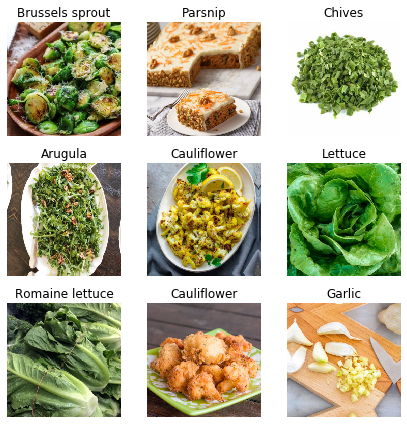

In [0]:
data.show_batch(rows=3, figsize=(6,6))

In [0]:
print(data.classes)
print(len(data.classes), data.c)
print(len(data.valid_dl), len(data.train_dl))

['Artichoke', 'Arugula', 'Asparagus', 'Avocado', 'Baby Carrot', 'Beet', 'Bell pepper', 'Black Beans', 'Broccoli', 'Brussels sprout', 'Cabbage', 'Carrot', 'Cauliflower', 'Celery', 'Chives', 'Corn', 'Cucumber', 'Edamame', 'Eggplant', 'Garlic', 'Ginger', 'Green bean', 'Green bell pepper', 'Habanero chili', 'JalapeÃ±o', 'Kale', 'Leek', 'Lettuce', 'Lima Bean', 'Mushroom', 'Olives', 'Onion', 'Parsnip', 'Pea', 'Pinto Beans', 'Potato', 'Pumpkin', 'Radish', 'Red Cabbage', 'Red bell pepper', 'Red onion', 'Romaine lettuce', 'Snap pea', 'Spinach', 'Squash', 'Turnip', 'Yams', 'Yellow onion', 'Zucchini']
49 49
7 27


In [0]:
for label in data.classes:
  path_for_label = base_dir/'downloads'/label
  verify_images(path_for_label)

## Train CNN Model
### Lets use ResNet34 - Proven Model

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:03<00:00, 25.6MB/s]


In [0]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,4.490728,1.918236,0.503356,00:42
1,2.861470,1.559530,0.411633,00:42
2,1.976320,1.392448,0.380313,00:42
3,1.455102,1.348655,0.351230,00:42


In [0]:
learn.save(Path(base_dir/'models'/'stage-1'), with_opt=True,return_path=True)

PosixPath('/content/gdrive/My Drive/Colab Notebooks/Vegetable Classifier/models/stage-1.pth')

In [0]:
interp = ClassificationInterpretation.from_learner(learn)
losses, idxs = interp.top_losses()
len(data.valid_ds)==len(losses)==len(idxs)

True

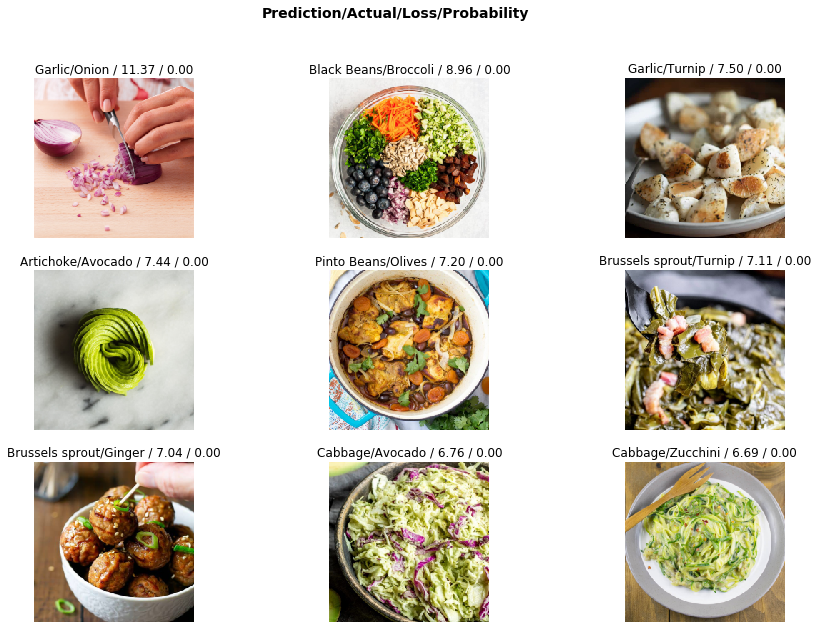

In [0]:
interp.plot_top_losses(9, figsize=(15,10))

In [0]:
learn.unfreeze()

In [0]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,1.357575,1.526991,0.409396,00:42


In [0]:
learn.load(Path(base_dir/'models'/'stage-1'))

Learner(data=ImageDataBunch;

Train: LabelList (1789 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Artichoke,Artichoke,Artichoke,Artichoke,Artichoke
Path: /content/gdrive/My Drive/Colab Notebooks/Vegetable Classifier;

Valid: LabelList (447 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Spinach,Black Beans,Corn,Parsnip,Lima Bean
Path: /content/gdrive/My Drive/Colab Notebooks/Vegetable Classifier;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_s

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


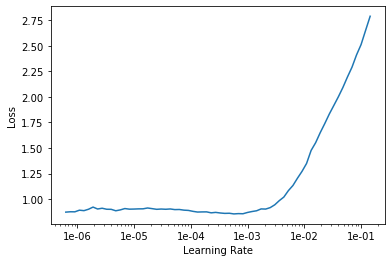

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.unfreeze()
learn.fit_one_cycle(20, max_lr=slice(7e-4,1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.921489,1.268633,0.344519,00:42
1,0.807414,1.279046,0.346756,00:42
2,0.720054,1.635881,0.387025,00:42
3,0.861708,2.518504,0.559284,00:42
4,1.130395,2.621041,0.563758,00:43
5,1.294861,2.849742,0.588367,00:42
6,1.224243,1.838123,0.503356,00:42
7,1.097824,1.671397,0.465324,00:42
8,1.001878,1.701406,0.429530,00:42
9,0.861247,1.761640,0.404922,00:42


In [0]:
learn.save(Path(base_dir/'models'/'BestModel'), with_opt=True,return_path=True)

PosixPath('/content/gdrive/My Drive/Colab Notebooks/Vegetable Classifier/models/BestModel.pth')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 7.59E-05
Min loss divided by 10: 7.59E-08


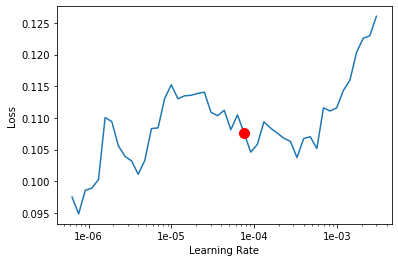

In [0]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [0]:
learn.unfreeze()
learn.load(Path(base_dir/'models'/'BestModel'))

Learner(data=ImageDataBunch;

Train: LabelList (1789 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Artichoke,Artichoke,Artichoke,Artichoke,Artichoke
Path: /content/gdrive/My Drive/Colab Notebooks/Vegetable Classifier;

Valid: LabelList (447 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
Chives,Cabbage,Corn,Cabbage,Potato
Path: /content/gdrive/My Drive/Colab Notebooks/Vegetable Classifier;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 

In [0]:
import matplotlib.pyplot as plt
from PIL import Image
test_imgs_path = base_dir/'TestImages'

img_folder = os.listdir(test_imgs_path)    
for img in img_folder:
    print("Read", img)
    im = open_image(test_imgs_path/img)
    print(learn.predict(im))

Read IMG_20191228_135509.jpg
(Category Kale, tensor(25), tensor([6.0684e-07, 6.3390e-06, 7.0983e-05, 9.0643e-07, 5.0810e-05, 6.7779e-06,
        5.3397e-06, 2.1432e-04, 7.9756e-05, 1.3542e-06, 8.2038e-05, 4.1267e-05,
        9.7254e-06, 5.8667e-05, 2.3216e-03, 2.1630e-05, 1.2296e-05, 7.9677e-07,
        5.0737e-05, 9.4831e-05, 1.3904e-05, 3.6793e-06, 9.4636e-05, 2.9425e-06,
        4.7242e-07, 9.9411e-01, 5.0085e-06, 1.3905e-03, 3.3950e-05, 8.2189e-06,
        1.2503e-06, 1.1758e-05, 1.0792e-04, 2.4708e-06, 4.7466e-06, 3.4579e-06,
        1.0047e-04, 1.0239e-06, 4.9407e-06, 1.0515e-05, 7.3953e-06, 7.5577e-04,
        1.6125e-06, 1.1452e-04, 3.2343e-05, 5.8509e-06, 1.6672e-05, 2.1520e-05,
        6.2447e-06]))
Read IMG_20191228_135459.jpg
(Category Romaine lettuce, tensor(41), tensor([7.1915e-05, 1.2273e-03, 2.0348e-05, 7.7536e-06, 3.7179e-06, 1.1178e-04,
        1.2365e-04, 4.8264e-06, 3.3809e-04, 4.3786e-04, 4.6745e-04, 1.4520e-06,
        1.0297e-04, 1.3887e-04, 9.0758e-05, 5.7289e-0

In [0]:
learn.export()